# Measurement Error Mitigation

* **Last Updated:** Feb 25, 2019
* **Requires:** qiskit-terra 0.7

The idea behind measurement error mitigation is to prepare all 2^n basis states and measure the probability of measuring counts in the other basis states. From these calibrations, we can correct the average results of another experiment of interest.

In [1]:
# Needed for functions
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Measurement calibration functions
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

from qiskit.ignis.mitigation.measurement import (measurement_calibration,
                                                       MeasurementFitter)

## 3 Qubit Example of the Calibration Matrices

Here we will generate a calibration matrix for 3 qubits in a 5 qubit sample

In [2]:
# Generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [3]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = measurement_calibration(qubit_list=[2,3,4], qr=qr, circlabel='mcal')

In [4]:
# Run the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
qobj = qiskit.compile(meas_calibs, backend=backend, shots=1000)
job = backend.run(qobj, noise_model=noise_model)
cal_results = job.result()

In [5]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [6]:
# Make a calibration matrix
meas_fitter = MeasurementFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.714 0.196 0.198 0.051 0.223 0.053 0.056 0.013]
 [0.087 0.6   0.031 0.166 0.021 0.169 0.01  0.053]
 [0.08  0.02  0.614 0.184 0.013 0.008 0.167 0.043]
 [0.006 0.079 0.068 0.506 0.002 0.017 0.022 0.157]
 [0.089 0.027 0.024 0.005 0.608 0.176 0.18  0.039]
 [0.012 0.072 0.001 0.017 0.068 0.497 0.015 0.131]
 [0.011 0.    0.062 0.014 0.059 0.023 0.503 0.128]
 [0.001 0.006 0.002 0.057 0.006 0.057 0.047 0.436]]


In [7]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 0.559750
Average Measurement Fidelity of Q0: 0.821625


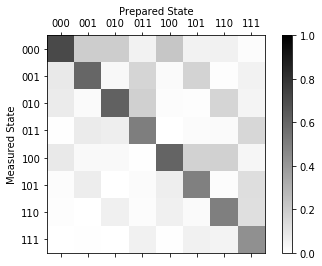

In [9]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

## Correct Measurement Noise on a 3Q GHZ State

In [10]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

qobj = qiskit.compile([ghz], backend=backend, shots=5000)
job = backend.run(qobj, noise_model=noise_model)
results = job.result()

In [11]:
# Results without mitigation
raw_counts = results.get_counts()

# Results with mitigation
mitigated_counts = meas_fitter.apply(raw_counts)

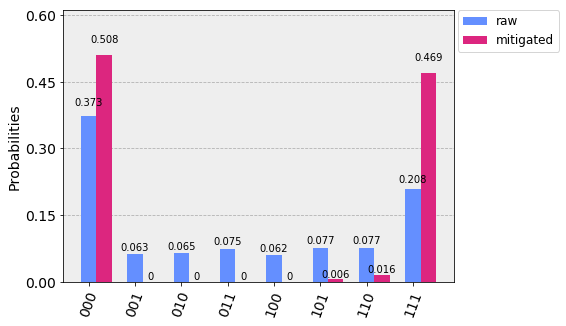

In [12]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])